### Load eval

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import random

import seaborn as sns
sns.set()

def peak_index(group, x_index, y_index):
    max_x, max_y = 0, -1

    for id_label, _ in group.iterrows():
        try:
            if group.at[id_label , y_index] is not None:
                if isinstance(group.at[id_label , y_index], pd.core.series.Series):
                    if len(group.at[id_label , y_index]) > 1:
                        new_v = group.at[id_label , y_index].iloc[0].item()
                    if len(group.at[id_label , y_index]) == 0:
                        continue
                else:
                    new_v = group.at[id_label , y_index]
#                 print(new_v)
                if new_v > max_y:
                    max_y = new_v
                    max_x = group.at[id_label , x_index]
        except Exception as e:
            print(group.at[id_label , y_index])
            print(type(group.at[id_label , y_index]))
            print(isinstance(group.at[id_label , y_index], pd.core.series.Series))
            print(len(group.at[id_label , y_index]))
            raise e
            
    return max_x, max_y

def plot_testing_curve(df, y_index, title=''):
    peak_box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
    
    fig, ax = plt.subplots(figsize=(16,5))
    for key, grp in df.groupby(['exp_name']): 
        ax = grp.plot(ax=ax, title=title, kind='line', x='step', y=y_index, label=key, style='-o', markersize=8.0, linewidth=4)
        peak_x, peak_y = peak_index(grp, x_index='step', y_index=y_index)
        variance = grp[y_index].var()
        ax.annotate('%s peak=%.3f (@step=%d)' % (key, peak_y, peak_x), xy=(peak_x, peak_y), textcoords='data', size=8, bbox=peak_box_props)
#         display(grp)
#         break

    plt.legend(loc='best')
    plt.show()


def best_testscores_by_dev(df, dev_dataset, test_dataset, anchor_metric_name):
    dev_df = df.loc[df['test_dataset'] == dev_dataset]
    test_df = df.loc[df['test_dataset'] == test_dataset]
    dev_df = dev_df.sort_values(by=anchor_metric_name, ascending=False)
    test_df = test_df.sort_values(by=anchor_metric_name, ascending=False)

    if len(dev_df) == 0: 
        print('No valid score found! Return None')
        return None

    if len(test_df) == 0: 
        print('No test score found! Return None')
        return None

    dev_row = dev_df.iloc[0].to_frame().transpose()
    
    test_row = None
    for idx, dev_row in dev_df.iterrows():
        best_step = dev_row.step
        test_row = test_df.loc[test_df.step == best_step]
        if len(test_row) == 1:
            dev_row = dev_row.to_frame().transpose()
            test_row = test_row.iloc[0].to_frame().transpose()
            break
        elif len(test_row) > 1:
            print('Found multiple rows (%d rows): exp=%s, data=%s' % (
                len(test_row), exp_name, str(dev_test_pair)))
            display(test_row)
            raise ValueError()
#     display(dev_row[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
#     display(test_row[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    return test_row

### Load all .eval

In [2]:
# fulldata
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_o2s_fulldata_devbest/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

    print(len(all_eval_df))
print(all_eval_df.test_dataset.unique())
print(all_eval_df.exp_name.unique())
print(all_eval_df.test_dataset.unique())

10
20
30
40
50
60
70
80
90
100
['stackex_test' 'openkp_valid2k_test' 'duc_test' 'kptimes_test'
 'openkp_test' 'kptimes_valid2k_test' 'stackex_valid2k_test'
 'jptimes_test' 'kp20k_valid2k_test' 'kp20k_test']
['bartFT_presabs_openkp_100k' 'bartFT_presabs_openkp_100k_rerun'
 'bartFT_presabs_kp20k_100k_rerun' 'transformer_presabs_stackex'
 'bartFT_presabs_kptimes_100k_rerun' 'transformer_presabs_openkp'
 'transformer_presabs_kptimes' 'bartFT_presabs_kp20k_100k'
 'bartFT_presabs_stackex_100k_rerun' 'transformer_presabs_kp20k']
['stackex_test' 'openkp_valid2k_test' 'duc_test' 'kptimes_test'
 'openkp_test' 'kptimes_valid2k_test' 'stackex_valid2k_test'
 'jptimes_test' 'kp20k_valid2k_test' 'kp20k_test']


### Plot Heatmap for Transfer Across Domains

In [3]:
short2long = {
# 'BART-KP20k': 'bartFT_presabs_kp20k_100k_rerun',
# 'BART-OpenKP': 'bartFT_presabs_openkp_100k_rerun',
# 'BART-KPTimes': 'bartFT_presabs_kptimes_100k_rerun',
# 'BART-StackEx': 'bartFT_presabs_stackex_100k_rerun',

'TF-KP20k': 'transformer_presabs_kp20k',
'TF-OpenKP': 'transformer_presabs_openkp',
'TF-KPTimes': 'transformer_presabs_kptimes',
'TF-StackEx': 'transformer_presabs_stackex'
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp_valid2k_test', 'openkp_test'),
                  ('kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex_valid2k_test', 'stackex_test')]
testname_map = {
    'kp20k_test': 'KP20k', 
    'openkp_test': 'OpenKP', 
    'kptimes_test': 'KPTimes', 
    'stackex_test': 'StackEx', 
}

anchor_metric_name = 'all_exact_f_score@k'
train_test_scores = {}

for short_name, exp_name in short2long.items():
    exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
    exp_grp = exp_grp.sort_values(by='step', ascending=True)

    print(exp_name, len(exp_grp))
    train_test_scores[long2short[exp_name]] = {}
    
#     display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
    for dev_dataset, test_dataset in dev_test_pairs:
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        train_test_scores[long2short[exp_name]][testname_map[test_dataset]] = best_test_row[anchor_metric_name].values[0]
        
print(train_test_scores)
        
# avg_bar_values = {'Beam': [], 'R@50': [], 'model': []}
# kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
# for k, v in bar_values.items():
#     _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
#     avg_bar_values['Beam'].append(int(k))
#     avg_bar_values['R@50'].append(np.mean(_v))
#     avg_bar_values['model'].append('TF')


transformer_presabs_kp20k 10
transformer_presabs_openkp 10
transformer_presabs_kptimes 10
transformer_presabs_stackex 10
{'TF-KP20k': {'KP20k': 0.2950610537355346, 'OpenKP': 0.0331670194536841, 'KPTimes': 0.0238392735042735, 'StackEx': 0.1173166666666666}, 'TF-OpenKP': {'KP20k': 0.0301053071419493, 'OpenKP': 0.183441689345832, 'KPTimes': 0.0518436904761904, 'StackEx': 0.0521833333333333}, 'TF-KPTimes': {'KP20k': 0.0092436171050924, 'OpenKP': 0.0286765447031549, 'KPTimes': 0.5025780158730159, 'StackEx': 0.0138125}, 'TF-StackEx': {'KP20k': 0.0405206069849953, 'OpenKP': 0.0104576151597621, 'KPTimes': 0.0042925793650793, 'StackEx': 0.5023770833333333}}


In [4]:
train_test_matrix = pd.DataFrame(data=train_test_scores)
train_test_matrix = train_test_matrix.transpose() * 100.0
display(train_test_matrix)

,KP20k,OpenKP,KPTimes,StackEx
TF-KP20k,29.506105,3.316702,2.383927,11.731667
TF-OpenKP,3.010531,18.344169,5.184369,5.218333
TF-KPTimes,0.924362,2.867654,50.257802,1.381250
TF-StackEx,4.052061,1.045762,0.429258,50.237708


<AxesSubplot:>

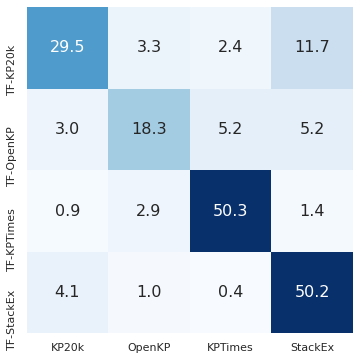

In [5]:
# sns.set_context("paper", rc={"font.size": 14,
#                              "axes.titlesize": 24,
#                              "axes.labelsize": 14,
#                              "xtick.labelsize": 14,
#                              "ytick.labelsize": 14,
#                              "legend.fontsize": 14})

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(train_test_matrix, 
            cmap='Blues',
#             cmap='Reds',
#             cmap='coolwarm', 
            annot=True, fmt=".1f", 
            annot_kws={'size':16},
            cbar=False,
            square=True,
#             xticklabels=False,
#             yticklabels=False
           )

### Plot Bar Charts for few-shot results

In [6]:
# TF-fewshot
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_fewshot_devbest/report/'
pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [7]:
short2long = {
'TF-KP20k-fewshot100': 'transformer-kp20k-fewshot100-lr3e4-step2k',
'TF-KP20k-fewshot1k': 'transformer-kp20k-fewshot1k-lr3e4-step4k',
'TF-KP20k-fewshot10k': 'transformer-kp20k-fewshot10k-lr3e4-step8k',
'TF-OpenKP-fewshot100': 'transformer-openkp-fewshot100-lr3e4-step2k',
'TF-OpenKP-fewshot1k': 'transformer-openkp-fewshot1k-lr3e4-step4k',
'TF-OpenKP-fewshot10k': 'transformer-openkp-fewshot10k-lr3e4-step8k', 
'TF-KPTimes-fewshot100': 'transformer-kptimes-fewshot100-lr3e4-step2k',
'TF-KPTimes-fewshot1k': 'transformer-kptimes-fewshot1k-lr3e4-step4k',
'TF-KPTimes-fewshot10k': 'transformer-kptimes-fewshot10k-lr3e4-step8k',
'TF-StackEx-fewshot100': 'transformer-stackex-fewshot100-lr3e4-step2k',
'TF-StackEx-fewshot1k': 'transformer-stackex-fewshot1k-lr3e4-step4k',
'TF-StackEx-fewshot10k': 'transformer-stackex-fewshot10k-lr3e4-step8k',

'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
'TF+DA-OpenKP-fewshot100': 'transformer-openkp-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-OpenKP-fewshot1k': 'transformer-openkp-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-OpenKP-fewshot10k': 'transformer-openkp-DA_step50k-FT_fewshot10k_step4k_lr1e5',
'TF+DA-KPTimes-fewshot100': 'transformer-kptimes-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-KPTimes-fewshot1k': 'transformer-kptimes-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-KPTimes-fewshot10k': 'transformer-kptimes-DA_step50k-FT_fewshot10k_step8k_lr1e5',
'TF+DA-StackEx-fewshot100': 'transformer-stackex-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-StackEx-fewshot1k': 'transformer-stackex-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-StackEx-fewshot10k': 'transformer-stackex-DA_step50k-FT_fewshot10k_step4k_lr1e5',

'TF+PT-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'TF+PT-OpenKP-fewshot100': 'transformer-openkp-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-OpenKP-fewshot1k': 'transformer-openkp-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-OpenKP-fewshot10k': 'transformer-openkp-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'TF+PT-KPTimes-fewshot100': 'transformer-kptimes-PT_step200k-FT_fewshot100_step2k_lr1e5',
'TF+PT-KPTimes-fewshot1k': 'transformer-kptimes-PT_step200k-FT_fewshot1k_step4k_lr1e5',
'TF+PT-KPTimes-fewshot10k': 'transformer-kptimes-PT_step200k-FT_fewshot10k_step8k_lr1e5',
'TF+PT-StackEx-fewshot100': 'transformer-stackex-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-StackEx-fewshot1k': 'transformer-stackex-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-StackEx-fewshot10k': 'transformer-stackex-PT_step200k-FT_fewshot10k_step4k_lr1e5',

# 'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
# 'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
# 'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
# 'TF+PT+DA-OpenKP-fewshot100': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
# 'TF+PT+DA-OpenKP-fewshot1k': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
# 'TF+PT+DA-OpenKP-fewshot10k': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
# 'TF+PT+DA-KPTimes-fewshot100': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot100_step2k_lr1e5',
# 'TF+PT+DA-KPTimes-fewshot1k': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot1k_step4k_lr1e5',
# 'TF+PT+DA-KPTimes-fewshot10k': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot10k_step8k_lr1e5',
# 'TF+PT+DA-StackEx-fewshot100': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
# 'TF+PT+DA-StackEx-fewshot1k': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
# 'TF+PT+DA-StackEx-fewshot10k': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0 if best_test_row is not None and len(best_test_row) > 0 else 0.0
        })
        
# print(train_test_scores)

transformer-kp20k-fewshot100-lr3e4-step2k 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot1k-lr3e4-step4k 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot10k-lr3e4-step8k 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-openkp-fewshot100-lr3e4-step2k 3 openkp_valid2k_test openkp_test
transformer-openkp-fewshot1k-lr3e4-step4k 3 openkp_valid2k_test openkp_test
transformer-openkp-fewshot10k-lr3e4-step8k 3 openkp_valid2k_test openkp_test
transformer-openkp-D

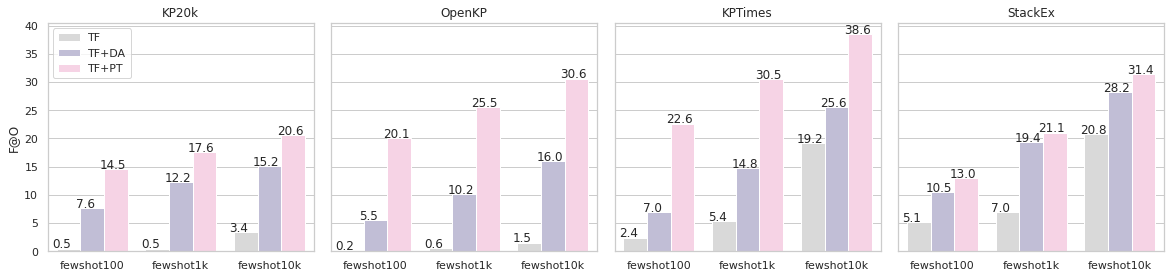

In [8]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[8], _set3[2], _set3[7], _set3[9]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() - 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("F@O")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)


### Present

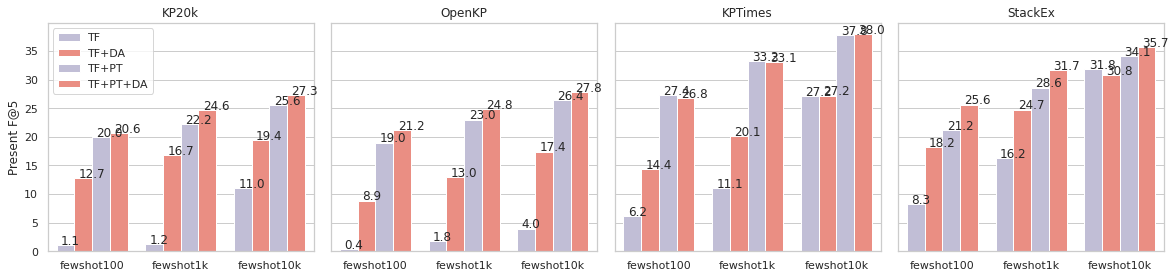

In [144]:
short2long = {
'TF-KP20k-fewshot100': 'transformer-kp20k-fewshot100-lr3e4-step2k',
'TF-KP20k-fewshot1k': 'transformer-kp20k-fewshot1k-lr3e4-step4k',
'TF-KP20k-fewshot10k': 'transformer-kp20k-fewshot10k-lr3e4-step8k',
'TF-OpenKP-fewshot100': 'transformer-openkp-fewshot100-lr3e4-step2k',
'TF-OpenKP-fewshot1k': 'transformer-openkp-fewshot1k-lr3e4-step4k',
'TF-OpenKP-fewshot10k': 'transformer-openkp-fewshot10k-lr3e4-step8k', 
'TF-KPTimes-fewshot100': 'transformer-kptimes-fewshot100-lr3e4-step2k',
'TF-KPTimes-fewshot1k': 'transformer-kptimes-fewshot1k-lr3e4-step4k',
'TF-KPTimes-fewshot10k': 'transformer-kptimes-fewshot10k-lr3e4-step8k',
'TF-StackEx-fewshot100': 'transformer-stackex-fewshot100-lr3e4-step2k',
'TF-StackEx-fewshot1k': 'transformer-stackex-fewshot1k-lr3e4-step4k',
'TF-StackEx-fewshot10k': 'transformer-stackex-fewshot10k-lr3e4-step8k',

'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
'TF+DA-OpenKP-fewshot100': 'transformer-openkp-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-OpenKP-fewshot1k': 'transformer-openkp-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-OpenKP-fewshot10k': 'transformer-openkp-DA_step50k-FT_fewshot10k_step4k_lr1e5',
'TF+DA-KPTimes-fewshot100': 'transformer-kptimes-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-KPTimes-fewshot1k': 'transformer-kptimes-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-KPTimes-fewshot10k': 'transformer-kptimes-DA_step50k-FT_fewshot10k_step8k_lr1e5',
'TF+DA-StackEx-fewshot100': 'transformer-stackex-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-StackEx-fewshot1k': 'transformer-stackex-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-StackEx-fewshot10k': 'transformer-stackex-DA_step50k-FT_fewshot10k_step4k_lr1e5',

'TF+PT-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'TF+PT-OpenKP-fewshot100': 'transformer-openkp-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-OpenKP-fewshot1k': 'transformer-openkp-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-OpenKP-fewshot10k': 'transformer-openkp-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'TF+PT-KPTimes-fewshot100': 'transformer-kptimes-PT_step200k-FT_fewshot100_step2k_lr1e5',
'TF+PT-KPTimes-fewshot1k': 'transformer-kptimes-PT_step200k-FT_fewshot1k_step4k_lr1e5',
'TF+PT-KPTimes-fewshot10k': 'transformer-kptimes-PT_step200k-FT_fewshot10k_step8k_lr1e5',
'TF+PT-StackEx-fewshot100': 'transformer-stackex-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-StackEx-fewshot1k': 'transformer-stackex-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-StackEx-fewshot10k': 'transformer-stackex-PT_step200k-FT_fewshot10k_step4k_lr1e5',

'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-OpenKP-fewshot100': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-OpenKP-fewshot1k': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-OpenKP-fewshot10k': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KPTimes-fewshot100': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot100_step2k_lr1e5',
'TF+PT+DA-KPTimes-fewshot1k': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot1k_step4k_lr1e5',
'TF+PT+DA-KPTimes-fewshot10k': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot10k_step8k_lr1e5',
'TF+PT+DA-StackEx-fewshot100': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-StackEx-fewshot1k': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-StackEx-fewshot10k': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'present_exact_f_score@5'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[2], _set3[3]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Present F@5")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

### Absent

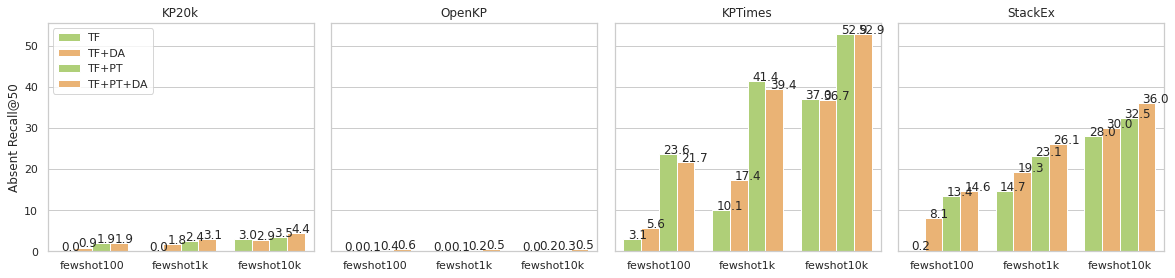

In [145]:
short2long = {
'TF-KP20k-fewshot100': 'transformer-kp20k-fewshot100-lr3e4-step2k',
'TF-KP20k-fewshot1k': 'transformer-kp20k-fewshot1k-lr3e4-step4k',
'TF-KP20k-fewshot10k': 'transformer-kp20k-fewshot10k-lr3e4-step8k',
'TF-OpenKP-fewshot100': 'transformer-openkp-fewshot100-lr3e4-step2k',
'TF-OpenKP-fewshot1k': 'transformer-openkp-fewshot1k-lr3e4-step4k',
'TF-OpenKP-fewshot10k': 'transformer-openkp-fewshot10k-lr3e4-step8k', 
'TF-KPTimes-fewshot100': 'transformer-kptimes-fewshot100-lr3e4-step2k',
'TF-KPTimes-fewshot1k': 'transformer-kptimes-fewshot1k-lr3e4-step4k',
'TF-KPTimes-fewshot10k': 'transformer-kptimes-fewshot10k-lr3e4-step8k',
'TF-StackEx-fewshot100': 'transformer-stackex-fewshot100-lr3e4-step2k',
'TF-StackEx-fewshot1k': 'transformer-stackex-fewshot1k-lr3e4-step4k',
'TF-StackEx-fewshot10k': 'transformer-stackex-fewshot10k-lr3e4-step8k',

'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
'TF+DA-OpenKP-fewshot100': 'transformer-openkp-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-OpenKP-fewshot1k': 'transformer-openkp-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-OpenKP-fewshot10k': 'transformer-openkp-DA_step50k-FT_fewshot10k_step4k_lr1e5',
'TF+DA-KPTimes-fewshot100': 'transformer-kptimes-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-KPTimes-fewshot1k': 'transformer-kptimes-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-KPTimes-fewshot10k': 'transformer-kptimes-DA_step50k-FT_fewshot10k_step8k_lr1e5',
'TF+DA-StackEx-fewshot100': 'transformer-stackex-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TF+DA-StackEx-fewshot1k': 'transformer-stackex-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TF+DA-StackEx-fewshot10k': 'transformer-stackex-DA_step50k-FT_fewshot10k_step4k_lr1e5',

'TF+PT-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'TF+PT-OpenKP-fewshot100': 'transformer-openkp-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-OpenKP-fewshot1k': 'transformer-openkp-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-OpenKP-fewshot10k': 'transformer-openkp-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'TF+PT-KPTimes-fewshot100': 'transformer-kptimes-PT_step200k-FT_fewshot100_step2k_lr1e5',
'TF+PT-KPTimes-fewshot1k': 'transformer-kptimes-PT_step200k-FT_fewshot1k_step4k_lr1e5',
'TF+PT-KPTimes-fewshot10k': 'transformer-kptimes-PT_step200k-FT_fewshot10k_step8k_lr1e5',
'TF+PT-StackEx-fewshot100': 'transformer-stackex-PT_step200k-FT_fewshot100_step1k_lr1e5',
'TF+PT-StackEx-fewshot1k': 'transformer-stackex-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'TF+PT-StackEx-fewshot10k': 'transformer-stackex-PT_step200k-FT_fewshot10k_step4k_lr1e5',

'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-OpenKP-fewshot100': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-OpenKP-fewshot1k': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-OpenKP-fewshot10k': 'transformer-openkp-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KPTimes-fewshot100': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot100_step2k_lr1e5',
'TF+PT+DA-KPTimes-fewshot1k': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot1k_step4k_lr1e5',
'TF+PT+DA-KPTimes-fewshot10k': 'transformer-kptimes-PT_step200k-DA_step20k-FT_fewshot10k_step8k_lr1e5',
'TF+PT+DA-StackEx-fewshot100': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-StackEx-fewshot1k': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-StackEx-fewshot10k': 'transformer-stackex-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'absent_exact_recall@50'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        

# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[6], _set3[5]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Absent Recall@50")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

### Plot different DA strategies (TL/NP/RS)

In [22]:
# fulldata
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_o2s_fulldata_devbest/report/'

# TF-fewshot
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_DA_devbest/report/'
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_fewshot_devbest/report/'

# BART-fewshot
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_bart_DA/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v1-DA1e6_FT1e5/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v2/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v3/report/'

# BART-mag
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_mag_fewshot/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [27]:
short2long = {
'NP-KP20k-fewshot100': 'transformer-kp20k-fewshot100-DA_NP_step50k-FT_step1k_lr1e5',
'NP-KP20k-fewshot1k': 'transformer-kp20k-fewshot1k-DA_NP_step50k-FT_step2k_lr1e5',
'NP-KP20k-fewshot10k': 'transformer-kp20k-fewshot10k-DA_NP_step50k-FT_step4k_lr1e5',

'RS-KP20k-fewshot100': 'transformer-kp20k-fewshot100-DA_RS_step50k-FT_step1k_lr1e5',
'RS-KP20k-fewshot1k': 'transformer-kp20k-fewshot1k-DA_RS_step50k-FT_step2k_lr1e5',
'RS-KP20k-fewshot10k': 'transformer-kp20k-fewshot10k-DA_RS_step50k-FT_step4k_lr1e5',
    
'TL-KP20k-fewshot100': 'transformer-kp20k-fewshot100-DA_TL_step50k-FT_step1k_lr1e5',
'TL-KP20k-fewshot1k': 'transformer-kp20k-fewshot1k-DA_TL_step50k-FT_step2k_lr1e5',
'TL-KP20k-fewshot10k': 'transformer-kp20k-fewshot10k-DA_TL_step50k-FT_step4k_lr1e5',

'TL+NP-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
'TL+NP-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
'TL+NP-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

transformer-kp20k-fewshot100-DA_NP_step50k-FT_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot1k-DA_NP_step50k-FT_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot10k-DA_NP_step50k-FT_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot100-DA_RS_step50k-FT_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot1k-DA_RS_step50k-FT_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot10k-DA_RS_step50k-FT_step4k_lr1e5 10 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot100-DA_TL_step50k-FT_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot1k-DA_TL_step50k-FT_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot10k-DA_TL_step50k-FT_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transfor

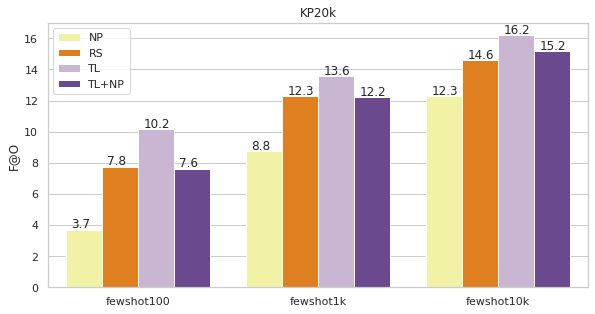

In [28]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_set2 = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Paired").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=1.0,
    palette=[_set2[10], _set2[7], _set2[8], _set2[9]]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() + 0.03, p.get_height() + 0.1), rotation=0)
axes.set_title(subbar_df['test_dataset'].iloc[0])
axes.set_xlabel("")

axes.set_ylabel("F@O")
axes.legend(loc='upper left')



### TL Zero-shot

In [29]:
# TF-DA-zeroshot
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_DA_devbest/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)


In [30]:
short2long = {
'DA-KP20k-zeroshot': 'transformer_DA_kp20k_step100k',
# 'NP-KP20k-zeroshot': 'transformer_DA-NP_kp20k_step100k',
# 'RS-KP20k-zeroshot': 'transformer_DA-RS_kp20k_step100k',
# 'TL-KP20k-zeroshot': 'transformer_DA-TL_kp20k_step100k',
'DA-OpenKP-zeroshot': 'transformer_DA_openkp_step100k',
'DA-KPTimes-zeroshot': 'transformer_DA_kptimes_step100k', 
'DA-StackEx-zeroshot': 'transformer_DA_stackex_step100k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['zeroshot']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

transformer_DA_kp20k_step100k 6 kp20k_valid2k_test kp20k_test
transformer_DA_openkp_step100k 6 openkp_valid2k_test openkp_test
transformer_DA_kptimes_step100k 8 kptimes_valid2k_test kptimes_test
transformer_DA_stackex_step100k 6 stackex_valid2k_test stackex_test


No handles with labels found to put in legend.


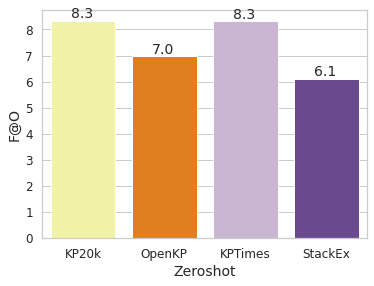

In [31]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

_set2 = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Paired").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(5, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df

sns.set_context("paper", font_scale=1.0, rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 18,
                             "legend.fontsize": 18})

sns.set(font_scale=1.2,
        rc={"font.size": 14,
            "axes.titlesize": 24,
            "axes.labelsize": 20,
            "xtick.labelsize": 20,
            "ytick.labelsize": 20,
            "legend.fontsize": 20})
g = sns.barplot(
    data=subbar_df,
    x="test_dataset", y="score",
    ax=axes, alpha=1.0,
    palette=[_set2[10], _set2[7], _set2[8], _set2[9]]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.1), rotation=0)
# axes.set_title(subbar_df['test_dataset'].iloc[0])
# axes.set_xticklabels([])
axes.set_xlabel("Zeroshot", fontsize=14)
axes.set_ylabel("F@O",fontsize=14)
# _, ylabels = plt.yticks()
# g.set_yticklabels(ylabels, size=15)
axes.legend(loc='upper left')
g.tick_params(labelsize=12)

axes.legend([],[], frameon=False)

### BART fewshot

In [102]:
# BART-fewshot
report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v1_DA1e6_FT1e5_devbest/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v3_devbest/report/'
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [103]:
short2long = {
'BART-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
'BART-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
'BART-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART-OpenKP-fewshot100': 'bart_presabs_openkp_fewshot100',
'BART-OpenKP-fewshot1k': 'bart_presabs_openkp_fewshot1k',
'BART-OpenKP-fewshot10k': 'bart_presabs_openkp_fewshot10k_step10k_rerun', 
'BART-KPTimes-fewshot100': 'bart_presabs_kptimes_fewshot100',
'BART-KPTimes-fewshot1k': 'bart_presabs_kptimes_fewshot1k',
'BART-KPTimes-fewshot10k': 'bart_presabs_kptimes_fewshot10k_step10k_rerun',
'BART-StackEx-fewshot100': 'bart_presabs_stackex_fewshot100',
'BART-StackEx-fewshot1k': 'bart_presabs_stackex_fewshot1k',
'BART-StackEx-fewshot10k': 'bart_presabs_stackex_fewshot10k_step10k_rerun',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-OpenKP-fewshot100': 'bart-openkp-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-OpenKP-fewshot1k': 'bart-openkp-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-OpenKP-fewshot10k': 'bart-openkp-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-KPTimes-fewshot100': 'bart-kptimes-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-KPTimes-fewshot1k': 'bart-kptimes-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KPTimes-fewshot10k': 'bart-kptimes-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-StackEx-fewshot100': 'bart-stackex-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-StackEx-fewshot1k': 'bart-stackex-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-StackEx-fewshot10k': 'bart-stackex-fewshot10k-DA1e5_step1k-FT5e6_step4k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

bart_presabs_kp20k_fewshot100 3 kp20k_valid2k_test kp20k_test
bart_presabs_kp20k_fewshot1k 3 kp20k_valid2k_test kp20k_test
bart_presabs_kp20k_fewshot10k_step10k_rerun 3 kp20k_valid2k_test kp20k_test
bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k 3 kp20k_valid2k_test kp20k_test
bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k 3 kp20k_valid2k_test kp20k_test
bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k 3 kp20k_valid2k_test kp20k_test
bart_presabs_openkp_fewshot100 3 openkp_valid2k_test openkp_test
bart_presabs_openkp_fewshot1k 3 openkp_valid2k_test openkp_test
bart_presabs_openkp_fewshot10k_step10k_rerun 3 openkp_valid2k_test openkp_test
bart-openkp-fewshot100-DA1e5_step1k-FT5e6_step1k 3 openkp_valid2k_test openkp_test
bart-openkp-fewshot1k-DA1e5_step1k-FT5e6_step2k 3 openkp_valid2k_test openkp_test
bart-openkp-fewshot10k-DA1e5_step1k-FT5e6_step4k 3 openkp_valid2k_test openkp_test
bart_presabs_kptimes_fewshot100 4 kptimes_valid2k_test kptimes_test
bart_presabs_kptimes_fewshot1k 4 kptim

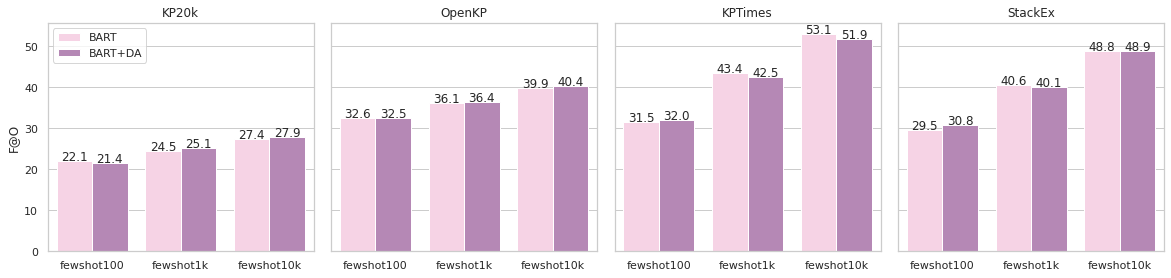

In [104]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[7], _set3[9]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")

    if fig_id == 0:
        axes[fig_id].set_ylabel("F@O")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)
        


#### present

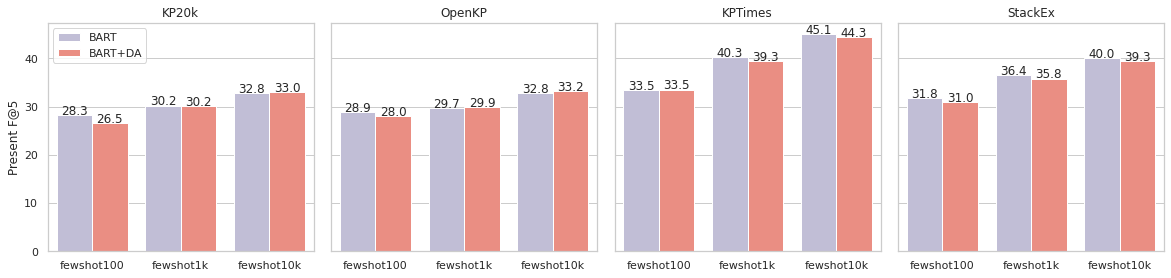

In [106]:
short2long = {
'BART-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
'BART-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
'BART-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART-OpenKP-fewshot100': 'bart_presabs_openkp_fewshot100',
'BART-OpenKP-fewshot1k': 'bart_presabs_openkp_fewshot1k',
'BART-OpenKP-fewshot10k': 'bart_presabs_openkp_fewshot10k_step10k_rerun', 
'BART-KPTimes-fewshot100': 'bart_presabs_kptimes_fewshot100',
'BART-KPTimes-fewshot1k': 'bart_presabs_kptimes_fewshot1k',
'BART-KPTimes-fewshot10k': 'bart_presabs_kptimes_fewshot10k_step10k_rerun',
'BART-StackEx-fewshot100': 'bart_presabs_stackex_fewshot100',
'BART-StackEx-fewshot1k': 'bart_presabs_stackex_fewshot1k',
'BART-StackEx-fewshot10k': 'bart_presabs_stackex_fewshot10k_step10k_rerun',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-OpenKP-fewshot100': 'bart-openkp-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-OpenKP-fewshot1k': 'bart-openkp-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-OpenKP-fewshot10k': 'bart-openkp-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-KPTimes-fewshot100': 'bart-kptimes-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-KPTimes-fewshot1k': 'bart-kptimes-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KPTimes-fewshot10k': 'bart-kptimes-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-StackEx-fewshot100': 'bart-stackex-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-StackEx-fewshot1k': 'bart-stackex-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-StackEx-fewshot10k': 'bart-stackex-fewshot10k-DA1e5_step1k-FT5e6_step4k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'present_exact_f_score@5'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[2], _set3[3]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Present F@5")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

#### absent

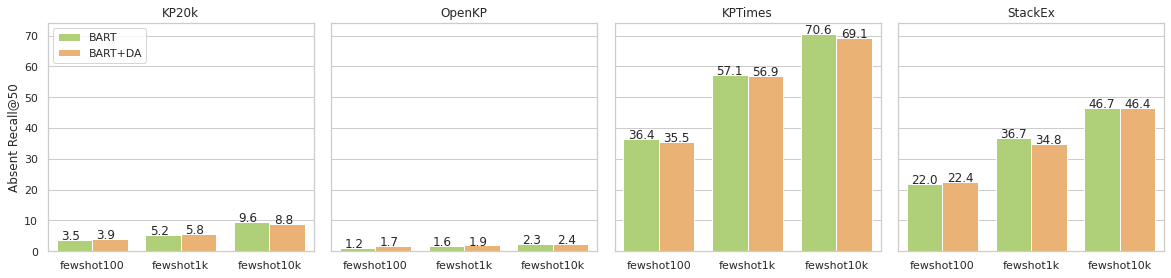

In [107]:
short2long = {
'BART-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
'BART-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
'BART-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART-OpenKP-fewshot100': 'bart_presabs_openkp_fewshot100',
'BART-OpenKP-fewshot1k': 'bart_presabs_openkp_fewshot1k',
'BART-OpenKP-fewshot10k': 'bart_presabs_openkp_fewshot10k_step10k_rerun', 
'BART-KPTimes-fewshot100': 'bart_presabs_kptimes_fewshot100',
'BART-KPTimes-fewshot1k': 'bart_presabs_kptimes_fewshot1k',
'BART-KPTimes-fewshot10k': 'bart_presabs_kptimes_fewshot10k_step10k_rerun',
'BART-StackEx-fewshot100': 'bart_presabs_stackex_fewshot100',
'BART-StackEx-fewshot1k': 'bart_presabs_stackex_fewshot1k',
'BART-StackEx-fewshot10k': 'bart_presabs_stackex_fewshot10k_step10k_rerun',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-OpenKP-fewshot100': 'bart-openkp-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-OpenKP-fewshot1k': 'bart-openkp-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-OpenKP-fewshot10k': 'bart-openkp-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-KPTimes-fewshot100': 'bart-kptimes-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-KPTimes-fewshot1k': 'bart-kptimes-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KPTimes-fewshot10k': 'bart-kptimes-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-StackEx-fewshot100': 'bart-stackex-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-StackEx-fewshot1k': 'bart-stackex-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-StackEx-fewshot10k': 'bart-stackex-fewshot10k-DA1e5_step1k-FT5e6_step4k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'absent_exact_recall@50'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        

# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[6], _set3[5]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Absent Recall@50")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

### DA-MagTL

In [7]:
# BART-mag
report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_mag_fewshot_devbest/report/'
pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_o2s_fulldata_devbest'
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v1_DA1e6_FT1e5_devbest/report/'
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_fewshot_devbest/report/'
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)
    
report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v3_devbest/report/'
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)
    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/empirical_mag/report/'
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
#     print(fname, len(df))
#     print(df.pred_name.unique())
    df = df.sort_values(by='step', ascending=True)    
    all_eval_df = pd.concat([all_eval_df, df], sort=True)


#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [10]:
short2long = {
# 'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
# 'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
# 'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
# 'TF+DA-KP20k-full': 'transformer_presabs_kp20k',
'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KP20k-full': 'transformer-kp20k-PT_step200k-DA_step20k-FT_full_step100k_lr5e5_warmup10k',

'TF+MagDA-KP20k-fewshot100': 'transformer-kp20k-DA_mag_step500k-FT_fewshot100_step1k_lr1e5',
'TF+MagDA-KP20k-fewshot1k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot1k_step2k_lr1e5',
'TF+MagDA-KP20k-fewshot10k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot10k_step4k_lr1e5',
'TF+MagDA-KP20k-full': 'transformer-kp20k-DA_mag_step500k-FT_full_step100k_lr1e5',

'TF+PT+MagDA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_mag_step100k-FT_fewshot100_step1k_lr1e5',
'TF+PT+MagDA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_mag_step100k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+MagDA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_mag_step100k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+MagDA-KP20k-full': 'transformer-kp20k-PT_step200k-DA_mag_step100k-FT_full_step100k_lr5e5_warmup10k',
# 'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step1k-FT5e6_step1k',
# 'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
# 'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
# 'BART+DA-KP20k-full': 'bartFT_presabs_kp20k_100k_rerun',

'BART-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
'BART-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
'BART-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART-KP20k-full': 'bartFT_presabs_kp20k_100k_rerun',

'BART+MagDA-KP20k-fewshot100': 'bart-MagTL_step100k-FT_kp20k_fewshot100_lr5e6_step1k',
'BART+MagDA-KP20k-fewshot1k': 'bart-MagTL_step100k-FT_kp20k_fewshot1k_lr5e6_step2k',
'BART+MagDA-KP20k-fewshot10k': 'bart-MagTL_step100k-FT_kp20k_fewshot10k_lr5e6_step4k',
'BART+MagDA-KP20k-full': 'bart-MagTL_step100k-kp20k_full_lr1e5_step100k',
# 'BART+MagDA-KP20k-full': 'bart-MagTL_step100k-kp20k_full_lr1e5_step50k',
    
'TF-KP20k-full': 'transformer_presabs_kp20k',
'PrevSOTA-KP20k-full': 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]

        if not short_name.startswith('TF') and not short_name.startswith('BART'):
            dev_dataset = dev_dataset[:-5]
            test_dataset = test_dataset[:-5]
        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-DA_step20k-FT_full_step100k_lr5e5_warmup10k 6 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_mag_step500k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_mag_step500k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_mag_step500k-FT_fewshot10k_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-DA_mag_step500k-FT_full_step100k_lr1e5 21 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-DA_mag_step100k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-DA_mag_step100k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-

['#cab2d6', '#6a3d9a', '#fb9a99', '#e31a1c', '#ffff99', '#b15928']


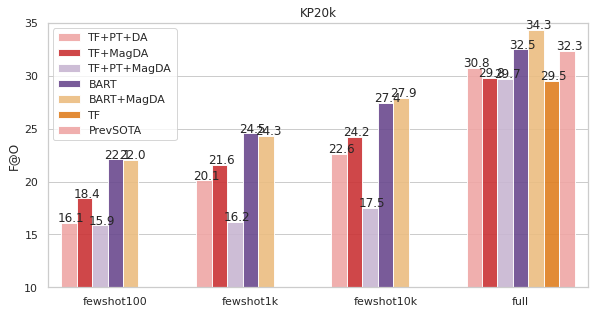

In [11]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_husl = sns.color_palette("husl").as_hex()
_paired = sns.color_palette("Paired").as_hex()
_set2 = sns.color_palette("Set2").as_hex()

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

print(_paired[8:10] + _paired[4:6] + _paired[10:12])
g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=0.9,
    palette=_paired[4:6] + _paired[8:10] + _paired[6:8]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() - 0.025, p.get_height() + 0.1), rotation=0)
axes.set_title(subbar_df['test_dataset'].iloc[0])
axes.set_xlabel("")

axes.set(ylim=(10, 35))
axes.set_ylabel("F@O")
axes.legend(loc='upper left')


#### present

['#cab2d6', '#6a3d9a', '#fb9a99', '#e31a1c', '#ffff99', '#b15928']


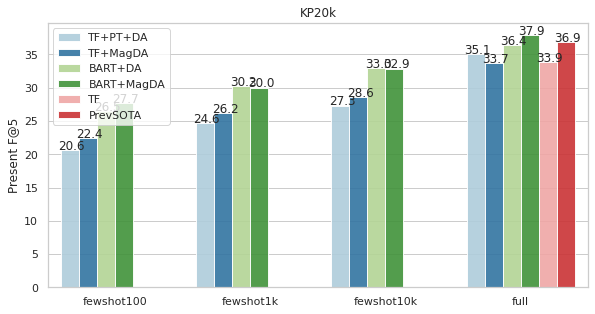

In [6]:
short2long = {
# 'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
# 'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
# 'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
# 'TF+DA-KP20k-full': 'transformer_presabs_kp20k',
'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KP20k-full': 'transformer-kp20k-PT_step200k-DA_step20k-FT_full_step100k_lr5e5_warmup10k',

'TF+MagDA-KP20k-fewshot100': 'transformer-kp20k-DA_mag_step500k-FT_fewshot100_step1k_lr1e5',
'TF+MagDA-KP20k-fewshot1k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot1k_step2k_lr1e5',
'TF+MagDA-KP20k-fewshot10k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot10k_step4k_lr1e5',
'TF+MagDA-KP20k-full': 'transformer-kp20k-DA_mag_step500k-FT_full_step100k_lr1e5',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
# 'BART+DA-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
# 'BART+DA-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
# 'BART+DA-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART+DA-KP20k-full': 'bartFT_presabs_kp20k_100k_rerun',
    
'BART+MagDA-KP20k-fewshot100': 'bart-MagTL_step100k-FT_kp20k_fewshot100_lr5e6_step1k',
'BART+MagDA-KP20k-fewshot1k': 'bart-MagTL_step100k-FT_kp20k_fewshot1k_lr5e6_step2k',
'BART+MagDA-KP20k-fewshot10k': 'bart-MagTL_step100k-FT_kp20k_fewshot10k_lr5e6_step4k',
'BART+MagDA-KP20k-full': 'bart-MagTL_step100k-kp20k_full_lr1e5_step50k',
    
'TF-KP20k-full': 'transformer_presabs_kp20k',
'PrevSOTA-KP20k-full': 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in short2long.items()}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'present_exact_f_score@5'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)
        
        if not short_name.startswith('TF') and not short_name.startswith('BART'):
            dev_dataset = dev_dataset[:-5]
            test_dataset = test_dataset[:-5]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_husl = sns.color_palette("husl").as_hex()
_paired = sns.color_palette("Paired").as_hex()
_set2 = sns.color_palette("Set2").as_hex()

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

print(_paired[8:10] + _paired[4:6] + _paired[10:12])
g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=0.9,
    palette=_paired
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() - 0.02, p.get_height() + 0.1), rotation=0)
axes.set_title(subbar_df['test_dataset'].iloc[0])
axes.set_xlabel("")

# axes.set(ylim=(10, 35))
axes.set_ylabel("Present F@5")
axes.legend(loc='upper left')


#### absent

['#cab2d6', '#6a3d9a', '#fb9a99', '#e31a1c', '#ffff99', '#b15928']


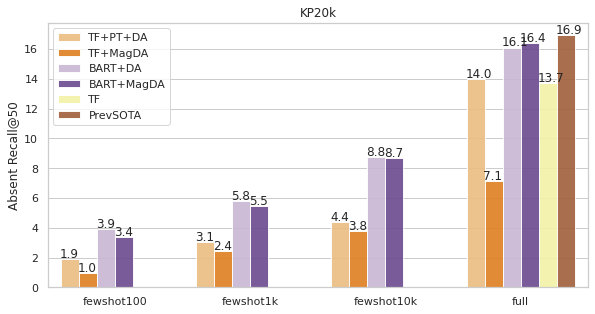

In [7]:
short2long = {
# 'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
# 'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
# 'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
# 'TF+DA-KP20k-full': 'transformer_presabs_kp20k',
'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KP20k-full': 'transformer-kp20k-PT_step200k-DA_step20k-FT_full_step100k_lr5e5_warmup10k',

'TF+MagDA-KP20k-fewshot100': 'transformer-kp20k-DA_mag_step500k-FT_fewshot100_step1k_lr1e5',
'TF+MagDA-KP20k-fewshot1k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot1k_step2k_lr1e5',
'TF+MagDA-KP20k-fewshot10k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot10k_step4k_lr1e5',
'TF+MagDA-KP20k-full': 'transformer-kp20k-DA_mag_step500k-FT_full_step100k_lr1e5',
    
'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
# 'BART+DA-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
# 'BART+DA-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
# 'BART+DA-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART+DA-KP20k-full': 'bartFT_presabs_kp20k_100k_rerun',
    
'BART+MagDA-KP20k-fewshot100': 'bart-MagTL_step100k-FT_kp20k_fewshot100_lr5e6_step1k',
'BART+MagDA-KP20k-fewshot1k': 'bart-MagTL_step100k-FT_kp20k_fewshot1k_lr5e6_step2k',
'BART+MagDA-KP20k-fewshot10k': 'bart-MagTL_step100k-FT_kp20k_fewshot10k_lr5e6_step4k',
'BART+MagDA-KP20k-full': 'bart-MagTL_step100k-kp20k_full_lr1e5_step50k',
    
'TF-KP20k-full': 'transformer_presabs_kp20k',
'PrevSOTA-KP20k-full': 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in short2long.items()}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'absent_exact_recall@50'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)
        
        if not short_name.startswith('TF') and not short_name.startswith('BART'):
            dev_dataset = dev_dataset[:-5]
            test_dataset = test_dataset[:-5]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_husl = sns.color_palette("husl").as_hex()
_paired = sns.color_palette("Paired").as_hex()
_set2 = sns.color_palette("Set2").as_hex()

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

print(_paired[8:10] + _paired[4:6] + _paired[10:12])
g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=0.9,
    palette=_paired[6:]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() - 0.01, p.get_height() + 0.1), rotation=0)
axes.set_title(subbar_df['test_dataset'].iloc[0])
axes.set_xlabel("")

# axes.set(ylim=(10, 35))
axes.set_ylabel("Absent Recall@50")
axes.legend(loc='upper left')


### Others

In [ ]:
# fulldata
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_o2s_fulldata_devbest/report/'

# TF-fewshot
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_DA_devbest/report/'
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_fewshot_devbest/report/'

# BART-fewshot
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_bart_DA/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v1-DA1e6_FT1e5/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v2/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v3/report/'

# BART-mag
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_mag_fewshot/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())